In [ ]:
## This is a series of examples demonstrating the use of the icanswim/cosmosis repo 
## for data science and machine learning projects.
## This repo is intended to be used as the boiler plate for data science and machine learning projects.
## See the icanswim/qchem repo for a demonstration of the use of this (icanswim/cosmosis) repo.

In [1]:
from model import FFNet, tv_model
from learning import Learn, Selector, Metrics
from dataset import CDataset, SKDS, TVDS
from dataset import ImageDatasetStats, AsTensor, SqueezeN, DType, Pad, EmbedLookup

from torch.optim import Adam
from torch.nn import MSELoss, CrossEntropyLoss
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import transforms

In [2]:
#example icanswim/cosmosis dataset (CDataset)
import numpy as np

class ExampleDataset(CDataset):
    
    embed_lookup = {'feature_4': {'a': 1,'b': 2,'c': 3,'d': 4, '0': 0},
                    'feature_3': {'z1': 1, 'y1': 2, 'x1': 3, '0': 0}}
    
    def load_data(self, boom='bust'):
        
        datadic = {1: {'feature_1': np.asarray([.04]),
                       'feature_2': np.asarray([[.02,.03],[.04,.05]]),
                       'feature_3': np.asarray(['z1']),
                       'feature_4': np.asarray(['c','c','d']),
                       'feature_5': np.asarray([1.1])},
                   2: {'feature_1': np.asarray([.03]),
                       'feature_2': np.asarray([[.1,.2],[.3,.4]]),
                       'feature_3': np.asarray(['x1','z1','y1']),
                       'feature_4': np.asarray(['d','a','d']),
                       'feature_5': np.asarray([1.2])}}
        
        
        
        print(boom)
        return datadic
    
class ExampleTransform():
    def __init__(self, num):
        self.num = num
        
    def __call__(self, arr):
        return np.add(arr, self.num)

    
feature_3 = ExampleDataset.embed_lookup['feature_3']
ds_params = {'train_params': {'input_dict': {'model_input': {'X1': ['feature_1','feature_5'],
                                                             'X2': ['feature_5'],
                                                             'embed': ['feature_3']},
                                             'criterion_input': {'target': ['feature_2'],
                                                                 'embed': ['feature_4']}},
                              'transforms': {'feature_1': [ExampleTransform(10), Pad((5,))],
                                             'feature_2': [Pad((3,3))],
                                             'feature_3': [Pad((4,)), EmbedLookup(feature_3)]},
                              'boom': 'bang'}}
    
d = ExampleDataset(**ds_params['train_params'])
d[1]

bang
CDataset created...


{'model_input': {'X1': array([10.04,  0.  ,  0.  ,  0.  ,  0.  ,  1.1 ]),
  'X2': array([1.1]),
  'embed': [array([1]), array([0]), array([0]), array([0])]},
 'criterion_input': {'target': array([[0.02, 0.03, 0.  ],
         [0.04, 0.05, 0.  ],
         [0.  , 0.  , 0.  ]]),
  'embed': array(['c', 'c', 'd'], dtype='<U1')}}

In [3]:
#example cosmosis sklearn regression dataset wrapper (SKDS)
ds_params = {'train_params': {'input_dict': {'model_input': {'features': ['X']},
                                             'criterion_input': {'target': ['y']}},
                              'dataset': 'make_regression',
                              'sk_params': {'n_samples': 100,
                                            'n_features': 5},
                              'features_dtype': 'float32',
                              'targets_dtype': 'float32'}}

sk = SKDS(**ds_params['train_params'])

sk[1]

creating scikit learn make_regression dataset...
CDataset created...


{'model_input': {'features': array([-0.33468255,  0.39085796,  0.6162301 ,  1.0191478 ,  0.7466209 ],
        dtype=float32)},
 'criterion_input': {'target': array([87.3938], dtype=float32)}}

In [2]:
#example cosmosis sklearn classification dataset wrapper (SKDS)
ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['X']},
                                             'criterion_input': {'target': ['y']}},
                              'features_dtype': 'float32',
                              'targets_dtype': 'int64',
                              'transforms': {'y': [],
                                             'X': [AsTensor()]},
                              'dataset': 'make_classification',
                              'sk_params': {'n_samples': 1000,
                                            'n_features': 30,
                                            'n_informative': 20,
                                            'n_clusters_per_class': 3,
                                            'flip_y': 0.05,
                                            'class_sep': 0.1,
                                            'n_classes': 4}}}

sk = SKDS(**ds_params['train_params'])

sk[1]['model_input']['X'].shape

creating scikit learn make_classification dataset...
CDataset created...


torch.Size([30])

In [5]:
#example cosmosis torchvision image dataset wrapper (TVDS)
ds_params={'dataset': 'MNIST',
           'input_dict': {'model_input': {'features': ['images'],},
                          'criterion_input': {'target': ['labels']}},
           'tv_params': {'root': './data/',
                         'train': True,
                         'download': True,
                         'transform': transforms.Compose([
                                           transforms.Resize(224)]),
                         'target_transform': None}}

tvds = TVDS(**ds_params)
tvds[1]

creating torch vision MNIST dataset...
CDataset created...


{'model_input': {'image': <PIL.Image.Image image mode=L size=224x224>},
 'criterion_input': {'target': 0}}

In [6]:
#example cosmosis torchvision image dataset wrapper (TVDS) with transforms and PIL stats
ds_params={'dataset': 'MNIST',
           'tv_params': {'root': './data/',
                         'train': True,
                         'download': True,
                         'transform': transforms.Compose([
                                           transforms.Resize(224)]),
                         'target_transform': None}}

tvds = TVDS(**ds_params)
ids = ImageDatasetStats(tvds)

print('mean: ', ids.stats.mean)
print('stddev: ', ids.stats.stddev)

#mean: 33.3/255 = .13
#stddev: 73.7/255 = .29

creating torch vision MNIST dataset...
CDataset created...
images to process: 60000
images processed: 10000
images processed: 20000
images processed: 30000
images processed: 40000
images processed: 50000
images processed: 60000
mean: [33.33091590401786], stddev: [73.70246726596685]
mean:  [33.33091590401786]
stddev:  [73.70246726596685]


creating scikit learn make_regression dataset...
CDataset created...
FFNet model loaded...
CModel loaded...
running model on gpu...
learning time: 0:00:01.585364
epoch: 0, lr: 0.01
train loss: 588686.8692129629, val loss: 423889.59375
learning time: 0:00:08.619584
epoch: 10, lr: 0.01
train loss: 11299.97312644676, val loss: 12041.482865767046
learning time: 0:00:13.548423
epoch: 17, lr: 0.0025
train loss: 9235.642297815393, val loss: 10022.801047585228
early stopping!  learning rate is below the set minimum...
test loss: 8303.927290482954
learning time: 0:00:13.804210


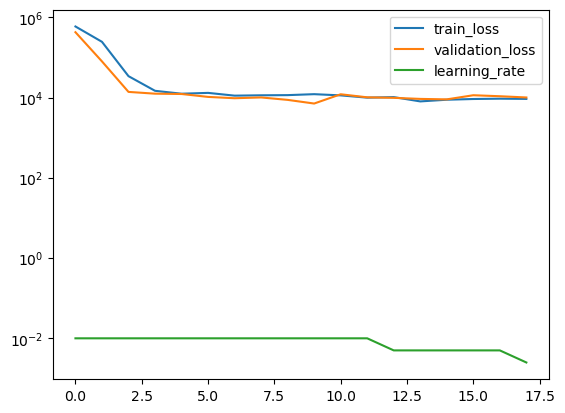

In [2]:
#example cosmosis sklearn regression dataset wrapper (SKDS) with sklearn metrics (Metrics) and 
#custom model (FFNet)
model_params = {'in_channels': 256, 
                'hidden': 512, 
                'out_channels': 1, 
                'model_name': 'funnel'}

ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['X']},
                                             'criterion_input': {'target': ['y']}},
                              'features_dtype': 'float32',
                              'targets_dtype': 'float32',
                              'dataset': 'make_regression',
                              'sk_params': {'n_samples':20000,
                                            'n_features': 256,
                                            'n_informative': 200}}}
             
metrics_params = {'report_interval': 10,
                  'log_plot': True,
                  'min_lr': .005} #break if learning rate falls below                        
             
opt_params = {'lr': 0.01}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_params = {'factor': .5, 
                'patience': 2,
                'cooldown': 2}

l = Learn([SKDS], 
          FFNet,
          Metrics=Metrics,
          Sampler=Selector, 
          Optimizer=Adam, 
          Scheduler=ReduceLROnPlateau, 
          Criterion=MSELoss,
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params, 
          batch_size=256, epochs=40, gpu=True)

creating scikit learn make_classification dataset...
CDataset created...
FFNet model loaded...
CModel loaded...
running model on gpu...
learning time: 0:00:03.452247
epoch: 0, lr: 0.01
train loss: 0.010772246065730358, val loss: 0.010517428748500653
sklearn train metric: 0.5443963124550317, sklearn validation metric: 0.5959432119638355
learning time: 0:00:24.333234
epoch: 6, lr: 0.01
train loss: 0.007510803175080336, val loss: 0.007756759782727712
sklearn train metric: 0.8272771380635653, sklearn validation metric: 0.8182592092271943
learning time: 0:00:38.299549
epoch: 10, lr: 0.01
train loss: 0.005911337472703103, val loss: 0.006543999279124869
sklearn train metric: 0.8987321187227446, sklearn validation metric: 0.8805765221537754
learning time: 0:00:59.257497
epoch: 16, lr: 0.01
train loss: 0.004585336323660345, val loss: 0.005568575020481506
sklearn train metric: 0.9387712810986013, sklearn validation metric: 0.9145706545200916
test loss: 0.005307504017717945
learning time: 0:01:10

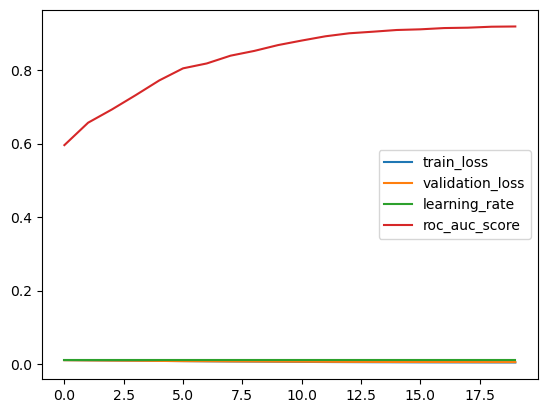

In [11]:
#example cosmosis sklearn classification dataset wrapper (SKDS) with sklearn metrics (Metrics) and 
#custom model (FFNet)
model_params = {'in_channels': 256, 
                'hidden': 128, 
                'out_channels': 4, 
                'model_name': 'funnel'}

ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['X']},
                                             'criterion_input': {'target': ['y']}},
                              'features_dtype': 'float32',
                              'targets_dtype': 'int64',
                              'transforms': {'y': [SqueezeN()],
                                             'X': []},
                              'dataset': 'make_classification',
                              'sk_params': {'n_samples': 100000,
                                            'n_features': 300,
                                            'n_informative': 200,
                                            'n_redundant': 5,
                                            'n_repeated': 5,
                                            'n_clusters_per_class': 5,
                                            'flip_y': 0.05,
                                            'class_sep': 0.05,
                                            'n_classes': 4}}}
                                     
metrics_params = {'report_interval': 20,
                  'log_plot': False,
                  'sk_metric_name': 'roc_auc_score',
                  'sk_params': {'average': 'macro',
                                'multi_class': 'ovr'}}

opt_params = {'lr': 0.01}

crit_params = {}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 1}

l = Learn([SKDS], 
          FFNet, 
          Sampler=Selector,
          Metrics=Metrics,
          Optimizer=Adam, 
          Scheduler=ReduceLROnPlateau, 
          Criterion=CrossEntropyLoss,
          model_params=model_params, ds_params=ds_params, 
          sample_params=sample_params, opt_params=opt_params, 
          sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          adapt=(300,256,.2), squeeze_y_pred=False, batch_size=128, epochs=20, save_model=False)

In [13]:
#example inference with cosmosis sklearn classification dataset wrapper (SKDS) and custom model (FFNet)
model_params = {'in_channels': 256, 
                'hidden': 128, 
                'out_channels': 4, 
                'model_name': 'funnel'}

ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['X']},
                                             'criterion_input': {'target': ['y']}},
                              'features_dtype': 'float32',
                              'targets_dtype': 'int64',
                              'dataset': 'make_classification',
                              'sk_params': {'n_samples': 10000,
                                            'n_features': 300,
                                            'n_informative': 200,
                                            'n_clusters_per_class': 3,
                                            'flip_y': 0.05,
                                            'class_sep': 0.1,
                                            'n_classes': 4}}}
                                     

metrics_params = {}
opt_params = {}
sample_params = {}
sched_params = {}

l = Learn([SKDS], 
          FFNet, 
          Sampler=Selector,
          Metrics=Metrics,
          Optimizer=Adam, 
          Scheduler=ReduceLROnPlateau, 
          Criterion=None,
          model_params=model_params, ds_params=ds_params, 
          sample_params=sample_params, opt_params=opt_params, 
          sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          batch_size=128, epochs=1, load_model='20221025_1522.pth')

creating scikit learn make_classification dataset...
CDataset created...
FFNet model loaded...
CModel loaded...
model loaded from pickle...
running model on gpu...
inference 2023-09-02 15:32:42.709062 complete and saved to csv...


creating torch vision CIFAR10 dataset...
Files already downloaded and verified
CDataset created...
creating torch vision CIFAR10 dataset...
Files already downloaded and verified
CDataset created...
torchvision model resnet18 loaded...
running model on gpu...
learning time: 0:00:04.899373
epoch: 0, lr: 0.01
train loss: 2.423422614574432, val loss: 2.059084044348809
sklearn train metric: 0.6093445235609262, sklearn validation metric: 0.7197751264783231
learning time: 0:00:15.412807
epoch: 3, lr: 0.01
train loss: 1.7418492221832276, val loss: 1.7242749737155052
sklearn train metric: 0.8118144954815794, sklearn validation metric: 0.8228342855840367
learning time: 0:00:26.032450
epoch: 6, lr: 0.01
train loss: 1.4777299468517304, val loss: 1.4900837367580784
sklearn train metric: 0.8666925592589049, sklearn validation metric: 0.8713541615069322
learning time: 0:00:36.570183
epoch: 9, lr: 0.005
train loss: 1.2778008279800415, val loss: 1.5412834229007844
sklearn train metric: 0.90122687666264

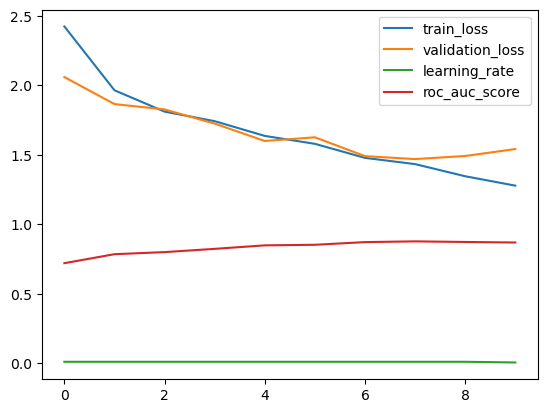

In [14]:
#example cosmosis torchvision image dataset wrapper (TVDS) with transforms and 
#torchvision model wrapper (tv_model)
model_params = {'model_name': 'resnet18',
                'in_channels': 3,
                'tv_params': {'num_classes': 10}}

ds_params={'train_params': {'dataset': 'CIFAR10',
                            'tv_params': {'root': './data/',
                                          'train': True,
                                          'download': True,
                                          'transform': transforms.Compose([
                                                           transforms.RandomRotation(10),
                                                           transforms.Resize(64),
                                                           transforms.ToTensor()]),
                                          'target_transform': None,
                                          'download': True}},
           'test_params': {'dataset': 'CIFAR10',
                           'tv_params': {'root': './data/',
                                         'train': False,
                                         'download': True,
                                         'transform': transforms.Compose([
                                                         transforms.Resize(64),
                                                         transforms.ToTensor()]),
                                         'target_transform': None,
                                         'download': True}}}

metrics_params = {'report_interval': 10, 
                  'sk_metric_name': 'roc_auc_score', 
                  'sk_params': {'average': 'macro',
                                'multi_class': 'ovr'}}

opt_params = {'lr': 0.01}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.8,),
                 'subset': .1}

sched_params = {'factor': .5,
                'patience': 1,
                'cooldown': 1}

l = Learn([TVDS,TVDS], 
          tv_model, 
          Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=CrossEntropyLoss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params, 
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params, 
          batch_size=16, epochs=10)

creating torch vision CIFAR10 dataset...
CDataset created...
creating torch vision CIFAR10 dataset...
CDataset created...
torchvision model resnext50_32x4d loaded...
running model on gpu...
learning time: 0:00:56.688063
epoch: 0, lr: 0.01
train loss: 2.6246955952644346, val loss: 2.1786789182693727
sklearn train metric: 0.5633334335574044, sklearn validation metric: 0.654452534852239
learning time: 0:01:53.689229
epoch: 1, lr: 0.01
train loss: 2.1185287504196166, val loss: 2.0684456729119822
sklearn train metric: 0.6785815748342092, sklearn validation metric: 0.7229921176750662
learning time: 0:02:51.730267
epoch: 2, lr: 0.01
train loss: 2.0340237584114074, val loss: 1.969255551215141
sklearn train metric: 0.718959952768528, sklearn validation metric: 0.7486349716133163
learning time: 0:03:48.774499
epoch: 3, lr: 0.01
train loss: 1.9723791570663451, val loss: 1.9444436277112653
sklearn train metric: 0.736695354512974, sklearn validation metric: 0.7561505093575189
learning time: 0:04:45

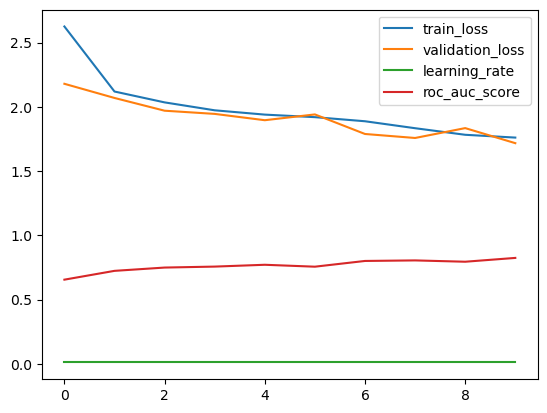

In [15]:
#example cosmosis torchvision dataset wrapper (TVDS) with transforms and 
#torchvision model wrapper (tv_model)
model_params = {'model_name': 'resnext50_32x4d',
                'in_channels': 3,
                'tv_params': {'num_classes': 10}}

ds_params={'train_params': {'dataset': 'CIFAR10',
                            'tv_params': {'root': './data/',
                                          'train': True,
                                          'transform': transforms.Compose([
                                                       transforms.RandomRotation(10),
                                                       transforms.Resize(256),
                                                       transforms.ToTensor()]),
                                          'target_transform': None}},
           'test_params': {'dataset': 'CIFAR10',
                           'tv_params': {'root': './data/',
                                         'train': False,
                                         'transform': transforms.Compose([
                                                      transforms.Resize(256),
                                                      transforms.ToTensor()]),
                                         'target_transform': None}}}

metrics_params = {'report_interval': 30, 
                  'sk_metric_name': 'roc_auc_score', 
                  'sk_params': {'average': 'macro',
                                'multi_class': 'ovr'}}

opt_params = {'lr': 0.01}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.8,),
                 'subset': .1}

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 2}

l = Learn([TVDS,TVDS], 
          tv_model, 
          Selector, 
          Optimizer=Adam, 
          Scheduler=ReduceLROnPlateau, 
          Criterion=CrossEntropyLoss, 
          model_params=model_params, ds_params=ds_params, 
          sample_params=sample_params, opt_params=opt_params, 
          sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          batch_size=16, epochs=10)